
# Ollama + Jupyter Guide

Welcome! This tutorial walks you through how to connect a Jupyter notebook to an **Ollama server**, enabling you to run large language models locally — similar to interacting with the OpenAI API, but **without the cost**.

# 🚀 Launching the Ollama Server on Yens GPU Cluster

Before you can send any prompts or run inference, you need to start the Ollama server.


📖  Refer to this [RCpedia blog post](https://rcpedia.stanford.edu/blog/2025/05/12/running-ollama-on-stanford-computing-clusters/) to launch your very own server!
<br>


In [1]:
import requests # This is for communicating with the HTTP server
import json # This is for formatting the requests and returns
import os
from IPython.display import display, Markdown, JSON

ollama_url = None
SCRATCH_BASE = f"/scratch/shared/{os.environ['USER']}"
# Attempt to read the host and port from scratch folder
try:
    with open(f"{SCRATCH_BASE}/ollama/host.txt") as f:
        HOST = f.read().strip()
    with open(f"{SCRATCH_BASE}/ollama/port.txt") as f:
        PORT = f.read().strip()
    ollama_url = f"http://{HOST}:{PORT}"
except Exception as e:
    print("[⚠️] Could not read host/port from scratch. If using someone else's server, manually set the `ollama_url` below.")
    # You can optionally provide a fallback manually here
    # ollama_url = 'http://HOST:PORT'  # Uncomment and modify if needed

# If no URL is available, raise an exception or pause
if ollama_url is None:
    raise ValueError("No Ollama server URL available. Please set `ollama_url` manually and run cell again")

# Parse server and port from the URL
server = ':'.join(ollama_url.split(':')[0:2])
port = ollama_url.split(':')[-1]

# Display interaction information
display(Markdown(f"""
# How can we interact with this server?

Once the server is running, you can interact with it by sending HTTP requests to its URL.

The server is running on **{server}**, and you need to contact it through port **{port}**.
"""))


# How can we interact with this server?

Once the server is running, you can interact with it by sending HTTP requests to its URL.

The server is running on **http://yen-gpu3**, and you need to contact it through port **58712**.


#### Check if server is running

In [2]:
try:
    r = requests.get(ollama_url)
    r.raise_for_status()
    print("✅ Success:", r.text)
except requests.exceptions.RequestException as e:
    print("❌ Failed to connect:", e)

✅ Success: Ollama is running


#### Preload model onto GPU

In [3]:
# Define the endpoint and payload
LLM_API_URL = f"{ollama_url}/api/chat"  # Could also be /api/generate
payload = {
    "model": "deepseek-r1:7b",
    "keep_alive": -1  # Keeps model loaded after request
}
headers = {"Content-Type": "application/json"}

# Send POST request
response = requests.post(LLM_API_URL, headers=headers, data=json.dumps(payload))
print(response.text)

{"model":"deepseek-r1:7b","created_at":"2025-05-14T22:25:32.745354643Z","message":{"role":"assistant","content":""},"done_reason":"load","done":true}


# Data Analysis Question

## Example: Can a LLM tell me how funny a joke is?

In [4]:
jokes = [
    '''What kind of shoes to frogs wear? Open-toad sandals.''',
    '''I just built an ATM that only gives out coins. I don’t know why no one’s thought of it before: it just makes cents!''',
    '''Did I ever tell you about the time I went mushroom foraging? It’s a story with a morel at the end.''',
    '''What happened when two slices of bread went on a date? It was loaf at first sight.''',
    '''Why do crabs never volunteer? Because they're shell-fish.''',
    '''I had a quiet game of tennis today. There was no racket.''',
    '''What's a shark's favorite saying? "Man overboard!"''',
    '''What did one slice of bread say to the other before the race? You're toast!''',
    '''I poured some water over a duck's back yesterday. I don't think he cared.''',
    '''I'm such a good navigator, a self-driving car once asked me for directions.''',
    '''Why do melons have weddings? They cantelope.''',
    '''What did the bison say to his son when he left the ranch? Bi-son.''',
    '''Watch what you say around the egg whites. They can't take a yolk.''',
    '''I'm so good at fixing things, my motto is, "If it is broke, I'll still fix it."''',
    '''Were did the pumpkins have their meeting? In the gourdroom.''',
    '''What's the best way to save your dad jokes? In a dadda-base.''',
    '''I got a new pen that can write under water. It can write other words too.''',
    '''My boss said “dress for the job you want, not for the job you have.” So I went in as Batman.''',
    '''I went to the aquarium this weekend, but I didn’t stay long. There’s something fishy about that place.''',
    '''Why can't dinosaurs clap their hands? Because they're extinct.''',
    '''I gave my handyman a to-do list, but he only did jobs 1, 3, and 5. Turns out he only does odd jobs.''',
    '''The Company may use derivative instruments to partially offset its business exposure to foreign exchange and interest rate risk. However, the Company may choose not to hedge certain exposures for a variety of reasons''',
    '''We are exposed to financial market risks, including changes in interest rates and currency exchange rates. To mitigate these risks, we may utilize derivative financial instruments, among other strategies. We do not use derivative financial instruments for speculative purposes.''',
    '''Check the appropriate box to designate whether you are a cat:
o	I am a cat.
x	I am not a cat.
 ''']


### 🔧 Sending a Request to the Ollama Chat API


##### 1. **Header** – Defines the format and type of the request and response

```json
{
  "Content-Type": "application/json"
}
```


##### 2. **URL** – The address to which you are sending the request
`http://HOST:PORT/api/chat` <br>
>**Format:** http://{OLLAMA_SERVER_URL}:{PORT}/api/{ENDPOINT}<br>
##### 3. **Payload** – The body of the request
This depends on the endpoint being used. For the `/api/chat` endpoint, the payload typically looks like:
``` json
{
    "model": "deepseek-r1:7b",  # Specify the model to use
    "messages": [
        {"role": "system", "content": system_prompt}, #System prompt for chat template
        {"role": "user", "content": user_prompt}
    ],
    "stream": False #Return it all at one time
}

```

#### System Prompt Declaration

The system prompt in a large language model (LLM) sets the initial behavior and tone of the model by defining its role, goals, and constraints before any user input is given. It acts as an invisible instruction that shapes all future responses by providing context, personality, and rules for how the model should act.

In [5]:
system_prompt = '''
You are HumorCritic-v1, an impartial humor analyst.  
Goal: For every joke you receive, produce (a) a *structured rating* of funniness on a 1–5 scale and (b) a short justification grounded in clear criteria.
{
  "overall_rating": <int 1–5>,
  "explanation": "word rationale explaining the why the joke got the overall rating it got"
}
If the input is not a joke or is too ambiguous, set score to 0 and explain.
'''
print(system_prompt)


You are HumorCritic-v1, an impartial humor analyst.  
Goal: For every joke you receive, produce (a) a *structured rating* of funniness on a 1–5 scale and (b) a short justification grounded in clear criteria.
{
  "overall_rating": <int 1–5>,
  "explanation": "word rationale explaining the why the joke got the overall rating it got"
}
If the input is not a joke or is too ambiguous, set score to 0 and explain.



#### User prompt Declaration

The user prompt is the explicit input or question given to the LLM by the user. It tells the model what task to perform or information to generate, serving as the main instruction the model responds to in context.

In [6]:
user_prompt = f'''
Joke to Analyze:
{jokes[0]}
'''
print(user_prompt)


Joke to Analyze:
What kind of shoes to frogs wear? Open-toad sandals.



In [7]:
# Define the chat endpoint URL
LLM_API_URL = f"{ollama_url}/api/chat"

# Define request headers
headers = {
    "Content-Type": "application/json"
}

# Construct the payload for the chat request
payload = {
    "model": "deepseek-r1:7b",
    "messages": [
        {"role": "system", "content": system_prompt},  # System instructions to guide the model
        {"role": "user", "content": user_prompt}       # User input to be processed
    ],
    "stream": False  # Set to True for streamed responses
}

# Display the request configuration
print("[INFO] Chat API Request Configuration")
print("URL:     ", LLM_API_URL)
print("Headers: ", headers)
print("Payload: ", payload)

[INFO] Chat API Request Configuration
URL:      http://yen-gpu3:58712/api/chat
Headers:  {'Content-Type': 'application/json'}
Payload:  {'model': 'deepseek-r1:7b', 'messages': [{'role': 'system', 'content': '\nYou are HumorCritic-v1, an impartial humor analyst.  \nGoal: For every joke you receive, produce (a) a *structured rating* of funniness on a 1–5 scale and (b) a short justification grounded in clear criteria.\n{\n  "overall_rating": <int 1–5>,\n  "explanation": "word rationale explaining the why the joke got the overall rating it got"\n}\nIf the input is not a joke or is too ambiguous, set score to 0 and explain.\n'}, {'role': 'user', 'content': '\nJoke to Analyze:\nWhat kind of shoes to frogs wear? Open-toad sandals.\n'}], 'stream': False}


In [8]:
response=requests.post(LLM_API_URL,headers=headers,data=json.dumps(payload))
print(response.json()['message']['content'])

<think>
Okay, so I'm trying to figure out how to evaluate this joke. The question is asking me to act as HumorCritic-v1, which means I need to be impartial but analytical about humor. Let's break it down step by step.

First, the joke given is: "What kind of shoes do frogs wear? Open-toad sandals." Hmm, that sounds a bit tricky because frogs aren't known for wearing shoes, so the humor must come from an unexpected or clever play on words.

I remember that puns are a common source of humor. A pun happens when two words sound alike but have different meanings, creating a funny play. In this case, "toad" is part of both the animal and the footwear. So frogs wearing sandals with "toad" in the name—wait, frogs don't wear sandals, so that's unexpected.

Let me think about the structure. The first part sets up the question normally: what shoes do frogs wear? Then the punchline introduces a wordplay on "toad," which is both an animal (a frog's friend) and a part of the footwear. So it's a doub

### Structured Outputs

In [9]:
payload = {
    "model": "deepseek-r1:7b",
    "messages": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ],
    "format": {
        "type": "object",
        "additionalProperties": False,
        "properties": {
            "overall_rating": {
                "type": "integer",
                "minimum": 0,
                "maximum": 5
            },
            "explanation": {
                "type": "string",
                "minLength": 1,
                "maxLength": 1000
            }
        },
        "required": ["overall_rating", "explanation"]
    },
    "stream": False
}

🛠️ This format schema tells the model to return a JSON object with two fields:

- An overall_rating from 0 to 5

- An explanation string between 1 and 1000 characters

If the model supports schema-constrained generation, this will reduce hallucinated verbosity and enforce predictable output.

In [10]:
## Lets run it
response=requests.post(LLM_API_URL,headers=headers,data=json.dumps(payload))
json.loads(response.json()['message']['content'])

{'overall_rating': 5,
 'explanation': "This joke plays on the double meaning of 'toad' as both an animal and a river. The pun here is effective because it relies on the listener recognizing that frogs are typically associated with water (hence 'toad'), but the shoe is named 'open-toad sandals,' which combines this with the literal meaning of wearing shoes. It's cleverly constructed to create a humorous twist by capitalizing on the dual associations of the word, making it highly amusing."}

## All Data

In [11]:
# Shared payload schema
rating_schema = {
    "type": "object",
    "additionalProperties": False,
    "properties": {
        "overall_rating": {"type": "integer", "minimum": 0, "maximum": 5},
        "explanation": {"type": "string", "minLength": 1, "maxLength": 1000}
    },
    "required": ["overall_rating", "explanation"]
}

# Rating count histogram
count_list = [0] * 6  # Index 0–5 for ratings

# Process each joke
for joke in jokes:
    user_prompt = f"Joke:\n{joke}"
    
    payload = {
        "model": "deepseek-r1:7b",
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        "format": rating_schema,
        "stream": False
    }

    try:
        response = requests.post(LLM_API_URL, headers=headers, data=json.dumps(payload))
        response.raise_for_status()
        result = json.loads(response.json()["message"]["content"])

        rating = int(result["overall_rating"])
        explanation = result["explanation"]

        count_list[rating] += 1

        print(f"\nJOKE: {joke}")
        print(f"OVERALL RATING: {rating}")
        print(f"EXPLANATION: {explanation}")
        print("-" * 50)

    except Exception as e:
        print(f"⚠️ Error processing joke:\n{joke}")
        print("Exception:", e)
        print("-" * 50)


JOKE: What kind of shoes to frogs wear? Open-toad sandals.
OVERALL RATING: 5
EXPLANATION: The setup uses 'toads' as an animal, which is a pun on 't o a d s,' and the punchline 'Open-toad sandals' cleverly ties in both meanings effectively.
--------------------------------------------------

JOKE: I just built an ATM that only gives out coins. I don’t know why no one’s thought of it before: it just makes cents!
OVERALL RATING: 4
EXPLANATION: The humor here is situational and relies on the pun 'cents' referring to both currency and the play on words with 'just making cents'. The setup about an ATM that only gives coins sets up for this pun effectively. It's a clever use of wordplay but doesn’t quite land as a standout punchline.
--------------------------------------------------

JOKE: Did I ever tell you about the time I went mushroom foraging? It’s a story with a morel at the end.
OVERALL RATING: 5
EXPLANATION: The humor in this joke comes from playing on words related to mushrooms an

In [12]:
print("\n🎯 Joke Ratings Distribution:")
for rating, freq in enumerate(count_list):
    print(f"{rating} ⭐ {'█' * freq} ({freq})")


🎯 Joke Ratings Distribution:
0 ⭐  (0)
1 ⭐  (0)
2 ⭐  (0)
3 ⭐  (0)
4 ⭐ ██████ (6)
5 ⭐ ██████████████████ (18)


# Appendix

# Ollama API Commands

## Requests Tutorial

### 🔍 Understanding `requests.get()` and `requests.post()`

In the previous step, we used a **`GET` request** to check if the Ollama server was running:

```python
r = requests.get(ollama_url)
```

A **GET request** is used to retrieve data from a server — it’s like asking a question and getting a response. It **does not change anything** on the server.

In contrast, a **POST request** is used to send data to a server. This is commonly used to:

- Start a new task

- Submit user input

- Create a resource (like generating a response from a model)

Think of GET as: “What’s the current state of X?”
<br>
And POST as: “Here’s some data — do something with it.”

Here are some examples of GET requests

For a full list check out 
[Ollama REST API Documentation](https://www.postman.com/postman-student-programs/ollama-api/documentation/suc47x8/ollama-rest-api)

## What models are available to me

You're now interacting directly with the **REST API** exposed by the Ollama server. This means you can query it to check for available models, manage tasks, and more.

To see what models are currently available on your server, use the /api/tags endpoint:

In [13]:
r=requests.get(f'{ollama_url}/api/tags')
r.json()

{'models': [{'name': 'deepseek-r1:7b',
   'model': 'deepseek-r1:7b',
   'modified_at': '2025-05-14T10:09:32.074496179-07:00',
   'size': 4683075271,
   'digest': '0a8c266910232fd3291e71e5ba1e058cc5af9d411192cf88b6d30e92b6e73163',
   'details': {'parent_model': '',
    'format': 'gguf',
    'family': 'qwen2',
    'families': ['qwen2'],
    'parameter_size': '7.6B',
    'quantization_level': 'Q4_K_M'}}]}

This returns a list of models and associated metadata — such as:

- Model name ("name")

- Model size (File size in bytes (useful for estimating memory requirements))

- Model Details (e.g format, family, parameter_size)

💡 This list reflects what’s currently pulled and ready on your server — not the full set of models available through Ollama’s registry.

## What Models are currently running on the Server

In [14]:
r=requests.get(f'{ollama_url}/api/ps')
print(r.text)

{"models":[{"name":"deepseek-r1:7b","model":"deepseek-r1:7b","size":5986631680,"digest":"0a8c266910232fd3291e71e5ba1e058cc5af9d411192cf88b6d30e92b6e73163","details":{"parent_model":"","format":"gguf","family":"qwen2","families":["qwen2"],"parameter_size":"7.6B","quantization_level":"Q4_K_M"},"expires_at":"2317-08-24T15:13:28.572005959-07:00","size_vram":5986631680}]}


***

## Run a previously downloaded model

### Loading the model so its ready for requests

Before sending prompts, its easier ***to load the model into memory.*** This avoids hiccups later when we issue chat requests.


In [15]:
# Define the endpoint and payload
LLM_API_URL = f"{ollama_url}/api/chat"  # Could also be /api/generate
payload = {
    "model": "gemma3:4b",
    "keep_alive": -1  # Keeps model loaded after request
}
headers = {"Content-Type": "application/json"}

# Send POST request
response = requests.post(LLM_API_URL, headers=headers, data=json.dumps(payload))
print(response.text)

{"error":"model \"gemma3:4b\" not found, try pulling it first"}


### Pulling a New Model (If You Don't Have It Yet)
If the model isn’t downloaded on your server yet, use the **pull endpoint** first:

In [16]:
## Trying to run a model you don't have yet
LLM_API_URL = f"{ollama_url}/api/chat"
payload = {
    "model": "gemma3:12b",
    "keep_alive": -1
}
headers = {"Content-Type": "application/json"}

response = requests.post(LLM_API_URL, headers=headers, data=json.dumps(payload))
print(response.text)
# API Header, Data you are sending

{"error":"model \"gemma3:12b\" not found, try pulling it first"}


In [17]:
#Pulling a model this will send the model to where OLLAMA_MODELS environmental variable is
LLM_API_URL=f'{ollama_url}/api/pull' # Notice the pull api endpoint
payload={"model":'gemma3:4b'}
headers = {"Content-Type": "application/json"}
response=requests.post(LLM_API_URL,headers=headers,data=json.dumps(payload))
# API Header, Data you are sending

### Confirm Loaded Models
Check which models are currently loaded and ready to use

In [18]:
# Another way to check if it ran 
r=requests.get(f'{ollama_url}/api/ps')
r.json()

{'models': [{'name': 'deepseek-r1:7b',
   'model': 'deepseek-r1:7b',
   'size': 5986631680,
   'digest': '0a8c266910232fd3291e71e5ba1e058cc5af9d411192cf88b6d30e92b6e73163',
   'details': {'parent_model': '',
    'format': 'gguf',
    'family': 'qwen2',
    'families': ['qwen2'],
    'parameter_size': '7.6B',
    'quantization_level': 'Q4_K_M'},
   'expires_at': '2317-08-24T15:13:28.572005959-07:00',
   'size_vram': 5986631680}]}

This will list all running models, their names, sizes, families, and expiration timers.
As you can see if you ran all the cells above you should have 2 models currently running on the **SAME GPU**

### Check out the API Docs for more information
https://github.com/ollama/ollama/blob/main/docs/api.md

# Data Analysis Example (In Depth)

### Now how do we use these models in a more complex scenario?

We want to classify each string into a structured schema that reflects multiple subjective qualities. This is a complex, multi-dimensional task—one that can challenge even the most advanced language models.

For example, suppose we're evaluating jokes (or any creative text) using human-like criteria such as originality, clarity, emotional impact, and appropriateness. Our goal is not just to rate the content, but to understand *how* the model reasons about it.

To test the model’s robustness, we’ve also included a few control examples—sentences taken from SEC regulatory documents—mixed in with the jokes. These non-humorous, formal texts help us assess whether the model can distinguish between appropriate and inappropriate contexts for humor scoring, and whether it hallucinates patterns where none exist.


```json
{
  "originality": <int 1-5>,
  "incongruity": <int 1-5>,
  "clarity": <int 1-5>,
  "emotional_impact": <int 1-5>,
  "appropriateness": <int 1-5>,
  "overall_rating": <int 1-5>,
  "explanation": "<≤60-word rationale referencing the criteria>"
}
```

In [19]:
jokes = [
    '''What kind of shoes to frogs wear? Open-toad sandals.''',
    '''I just built an ATM that only gives out coins. I don’t know why no one’s thought of it before: it just makes cents!''',
    '''Did I ever tell you about the time I went mushroom foraging? It’s a story with a morel at the end.''',
    '''What happened when two slices of bread went on a date? It was loaf at first sight.''',
    '''Why do crabs never volunteer? Because they're shell-fish.''',
    '''I had a quiet game of tennis today. There was no racket.''',
    '''What's a shark's favorite saying? "Man overboard!"''',
    '''What did one slice of bread say to the other before the race? You're toast!''',
    '''I poured some water over a duck's back yesterday. I don't think he cared.''',
    '''I'm such a good navigator, a self-driving car once asked me for directions.''',
    '''Why do melons have weddings? They cantelope.''',
    '''What did the bison say to his son when he left the ranch? Bi-son.''',
    '''Watch what you say around the egg whites. They can't take a yolk.''',
    '''I'm so good at fixing things, my motto is, "If it is broke, I'll still fix it."''',
    '''Were did the pumpkins have their meeting? In the gourdroom.''',
    '''What's the best way to save your dad jokes? In a dadda-base.''',
    '''I got a new pen that can write under water. It can write other words too.''',
    '''My boss said “dress for the job you want, not for the job you have.” So I went in as Batman.''',
    '''I went to the aquarium this weekend, but I didn’t stay long. There’s something fishy about that place.''',
    '''Why can't dinosaurs clap their hands? Because they're extinct.''',
    '''I gave my handyman a to-do list, but he only did jobs 1, 3, and 5. Turns out he only does odd jobs.''',
    '''The Company may use derivative instruments to partially offset its business exposure to foreign exchange and interest rate risk. However, the Company may choose not to hedge certain exposures for a variety of reasons''',
    '''We are exposed to financial market risks, including changes in interest rates and currency exchange rates. To mitigate these risks, we may utilize derivative financial instruments, among other strategies. We do not use derivative financial instruments for speculative purposes.''',
    '''Check the appropriate box to designate whether you are a cat:
o	I am a cat.
x	I am not a cat.
 '''
]

### 🧭 System Prompt: Setting the Ground Rules
Before sending any data to the model, we define a system prompt—a kind of role-defining instruction that sets the context for the model’s behavior throughout the conversation.

In this case, we define the model as:

**"HumorCritic-v1, an impartial humor analyst."**

This primes the model to act like a structured, emotion-neutral evaluator rather than a casual chatbot. The prompt explicitly defines what the model should focus on: breaking down each joke into five quality dimensions (originality, incongruity, clarity, emotional impact, and appropriateness), assigning 1–5 scores to each, and giving a short **justification**.

To enforce consistency and control over formatting, we also specify the **exact JSON output structure the model should return.** This is crucial if you’re parsing responses downstream for analysis or visualization.

Key features:

 - Instructional tone avoids ambiguity.
 - Scoring rules are clearly defined, including how to calculate the overall score.
- Fallback behavior is included: if the input isn’t a joke, the model returns all 1s and explains why.

This makes it easier to evaluate both how well the model follows instructions and how reliable its judgments are across a range of inputs, including non-jokes.





### Chat API

In [20]:
# === Ollama Chat API Setup ===

# API endpoint for chat completion (constant for Ollama)
LLM_CHAT_API = f'{ollama_url}/api/chat'

# Standard headers required by the API
headers = {
    "Content-Type": "application/json"
}


# === System Prompt ===
# This sets the behavior and rules for the model throughout the session.
# It defines a fictional role "HumorCritic-v1" and instructs the model to rate jokes
# according to five human-centered criteria, then summarize the evaluation in JSON format.

system_prompt = '''
You are HumorCritic-v1, an impartial humor analyst.  
Goal: For every joke you receive, produce (a) a *structured rating* of funniness on a 1–5 scale and (b) a short justification grounded in clear criteria.

Definitions & criteria (score each 1–5, where 1 = very weak, 5 = excellent):
• Originality – is the joke novel or cliché?  
• Incongruity/Surprise – does the punchline subvert expectations?  
• Clarity/Structure – is the setup understandable and the punchline delivered cleanly?  
• Emotional Impact – how strongly would an average adult laugh or react?  
(Optional) • Appropriateness – is the humor likely acceptable to a general audience?

Overall Rating: the *rounded average* of Originality, Incongruity, Clarity, and Emotional Impact.  
(If Appropriateness < 3, cap Overall at 3.)

Output **exactly** the following JSON, nothing else:

{
  "originality": <int 1–5>,
  "incongruity": <int 1–5>,
  "clarity": <int 1–5>,
  "emotional_impact": <int 1–5>,
  "appropriateness": <int 1–5>,
  "overall_rating": <int 1–5>,
  "explanation": "<≤60-word rationale referencing the criteria>"
}

If the input is not a joke or is too ambiguous, set all scores to 1 and explain.
'''


# === User Prompt ===
# Inject a single joke into the prompt to be evaluated by the model.
# jokes[0] is assumed to be a joke string from your dataset.

user_prompt = f'''
Joke
{jokes[0]}
'''


# === API Payload ===
# Constructs the full request to be sent to the Ollama API.
# Includes the model to use, the conversation history (system + user prompts),
# and disables streaming for simpler output parsing.

payload = {
    "model": "deepseek-r1:7b",  # Specify the model to use
    "messages": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ],
    "stream": False
}


In [21]:
response=requests.post(LLM_CHAT_API,headers=headers,data=json.dumps(payload))
print(response.json()['message']['content'])

<think>
Alright, let's see what I need to do here. The user provided a joke about what kind of shoes frogs wear—“Open-toad sandals.” Okay, so my role is to act as HumorCritic-v1 and analyze this joke based on the given criteria.

First, I'll break down each component: Originality, Incongruity/Surprise, Clarity/Structure, Emotional Impact, and Appropriateness. Then I'll calculate the overall rating by averaging these scores, making sure to cap it at 3 if appropriateness is below 3.

Starting with Originality. The joke uses a play on words between "toad" and "toes." Wait, frogs don't wear sandals, right? So this is relying on that pun without introducing anything new or unique. It's more of a cliché than original because it's common in wordplay about animals.

Next, Incongruity/Surprise. The punchline subverts expectations by switching from shoes to a literal animal reference. But I think the surprise might be weak here because the setup already hints at an animal joke. So maybe not as s

## Structured Outputs

## 📌 Teaching Note: Why Output Control Matters
This example illustrates a key challenge when working with language models: **they are not deterministic** and often include reasoning or internal “thoughts” even when instructed to return only structured output.

Despite clear instructions in the system prompt to respond **only with a JSON block**, the model **prepended a `<think>`section**—a reflective, conversational explanation. While this is semantically useful for debugging or interpretability, it's problematic in production pipelines where we expect clean, machine-readable output.

### ❗ Why This Is a Problem
When processing large-scale inputs—thousands or even millions—this behavior introduces critical issues:

- 🧩 Parsing Overhead: You now need to implement additional logic (e.g., regex, schema validation) to extract valid JSON.

- 💥 Pipeline Fragility: If the model’s verbosity or formatting varies too much, downstream scripts may fail.

- 🔁 Reduced Prompt Reliability: Especially in batch inference, unexpected verbosity undermines consistency.

Although it’s possible to strip out non-JSON content with simple post-processing—like extracting the first valid JSON object—this approach adds unnecessary complexity and technical debt to your workflow.

### ✅ A Better Approach: Schema-Constrained Output
You can reduce these risks by explicitly defining and enforcing the expected output format using JSON Schema. This allows you to:

- Validate output structure automatically.

- Encourage more consistent model behavior.

- Avoid relying on fragile parsing logic.

Where supported, use tools that allow schema-guided decoding, which not only checks but constrains model output during generation.

You can find how to make these on 
https://json-schema.org/

In this example, we're telling the model:

"Return a JSON object (not free-form text)."

"Each field must be present, and each must match a specified type and range."

This schema acts as a contract between the user and the model. This is the **structured output** part of the payload

``` json
{
            "format": {
                "type": "object", #return a json object
                "additionalProperties":False, # Do not return any extra fields
                "properties": { # What you want to output with constaints
                    "originality": {"type": "integer", "minimum":0,"maximum":5},
                    "incongruity": {"type": "integer","minimum":0,"maximum":5},
                    "clarity": {"type": "integer", "minimum":0,"maximum":5},
                    "emotional_impact": {"type": "integer","minimum":0,"maximum":5},
                    "appropriateness": {"type": "integer", "minimum":0,"maximum":5},
                    "overall_rating": {"type": "integer","minimum":0,"maximum":5},
                    "explanation": {"type": "string","minLength":1,"maxLength":250},
                },
                # Whether the field is required
                "required":["originality","incongruity","clarity","emotional_impact","appropriateness","overall_rating","explanation"], 
            },


```


When this format is enforced, the model is more likely to return usable, predictable data—greatly simplifying post-processing and integration into pipelines or applications.



In [22]:
payload = {
            "model": 'deepseek-r1:7b',
            "messages": [
                {'role': 'system', 'content': system_prompt},
                {'role': 'user', 'content': user_prompt}
            ],
            "format": {
                "type": "object",
                "additionalProperties":False,
                "properties": {
                    "originality": {"type": "integer", "minimum":0,"maximum":5},
                    "incongruity": {"type": "integer","minimum":0,"maximum":5},
                    "clarity": {"type": "integer", "minimum":0,"maximum":5},
                    "emotional_impact": {"type": "integer","minimum":0,"maximum":5},
                    "appropriateness": {"type": "integer", "minimum":0,"maximum":5},
                    "overall_rating": {"type": "integer","minimum":0,"maximum":5},
                    "explanation": {"type": "string","minLength":1,"maxLength":250},
                },
                "required": ["originality","incongruity","clarity","emotional_impact","appropriateness","overall_rating","explanation"],
            },
            "stream": False,
        }

In [23]:
response=requests.post(LLM_CHAT_API,headers=headers,data=json.dumps(payload))
json_output=json.loads(response.json()['message']['content'])
json_output

{'originality': 4,
 'incongruity': 5,
 'clarity': 5,
 'emotional_impact': 5,
 'appropriateness': 5,
 'overall_rating': 5,
 'explanation': 'The joke is original and uses a cliché in a surprising way. The punchline is clear and effectively conveys the humor.'}

In [24]:
# Define the shared evaluation schema
joke_evaluation_schema = {
    "type": "object",
    "additionalProperties": False,
    "properties": {
        "originality": {"type": "integer", "minimum": 0, "maximum": 5},
        "incongruity": {"type": "integer", "minimum": 0, "maximum": 5},
        "clarity": {"type": "integer", "minimum": 0, "maximum": 5},
        "emotional_impact": {"type": "integer", "minimum": 0, "maximum": 5},
        "appropriateness": {"type": "integer", "minimum": 0, "maximum": 5},
        "overall_rating": {"type": "integer", "minimum": 0, "maximum": 5},
        "explanation": {"type": "string", "minLength": 1, "maxLength": 1000}
    },
    "required": [
        "originality", "incongruity", "clarity",
        "emotional_impact", "appropriateness",
        "overall_rating", "explanation"
    ]
}

# Process each joke
for joke in jokes:
    user_prompt = f"Joke:\n{joke}"

    payload = {
        "model": "deepseek-r1:7b",
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        "format": joke_evaluation_schema,
        "stream": False
    }

    try:
        response = requests.post(LLM_CHAT_API, headers=headers, data=json.dumps(payload))
        response.raise_for_status()
        content = response.json()['message']['content']
        result = json.loads(content)

        print("\n🃏 JOKE:", joke)
        print("⭐ OVERALL RATING:", result["overall_rating"])
        print("📖 EXPLANATION:", result["explanation"])
        print("🔍 COMPONENT SCORES:")
        for key in ["originality", "incongruity", "clarity", "emotional_impact", "appropriateness"]:
            print(f"  - {key.replace('_', ' ').capitalize()}: {result[key]}")
        print("-" * 60)

    except Exception as e:
        print(f"\n⚠️ Error evaluating joke:\n{joke}")
        print("Exception:", e)
        print("-" * 60)
    


🃏 JOKE: What kind of shoes to frogs wear? Open-toad sandals.
⭐ OVERALL RATING: 5
📖 EXPLANATION: The joke plays on the double meaning of 'toad' and 'sandals,' which is a clever twist. The setup is clear, and the punchline delivers an incongruous surprise that should elicit laughter.
🔍 COMPONENT SCORES:
  - Originality: 3
  - Incongruity: 4
  - Clarity: 5
  - Emotional impact: 4
  - Appropriateness: 5
------------------------------------------------------------

🃏 JOKE: I just built an ATM that only gives out coins. I don’t know why no one’s thought of it before: it just makes cents!
⭐ OVERALL RATING: 5
📖 EXPLANATION: The joke is original because combining an ATM with cents isn't a common idea. The pun is effective and the setup explains why it's funny, making it clear.
🔍 COMPONENT SCORES:
  - Originality: 5
  - Incongruity: 5
  - Clarity: 5
  - Emotional impact: 5
  - Appropriateness: 5
------------------------------------------------------------

🃏 JOKE: Did I ever tell you about the 

# 🧠 Multimodal Models: Can They Decode Humor From Images?

Now let’s flip the script and explore the image-processing capabilities of models like gemma:4b, which can accept both text and image inputs.

We’ll present the model with a comic image generated from one of the jokes and ask it to reverse-engineer or describe the underlying humor. This tests not only its image recognition skills, but also its ability to connect visual context to abstract, linguistic humor.

This kind of **multimodal backtracing** is still very experimental, and there are several important design questions to keep in mind:

- **How do we encode and send the image?**
Most multimodal APIs accept base64-encoded images or image URLs. We’ll need to package the image properly in the request payload. During this step we also need to think about what size is the image as this translates directly to tokens

- **Is the model actually capable of this task?**
While these models are trained on paired text-image data, that doesn’t mean they can infer a punchline or understand irony in the same way a human does. This task stretches the model’s ability to reason across modalities.

- **What kind of output should we expect?**
We might ask the model to:

  - Identify the joke or its theme
  - Reconstruct the punchline
  - Rate the humor in the image

### Example Image

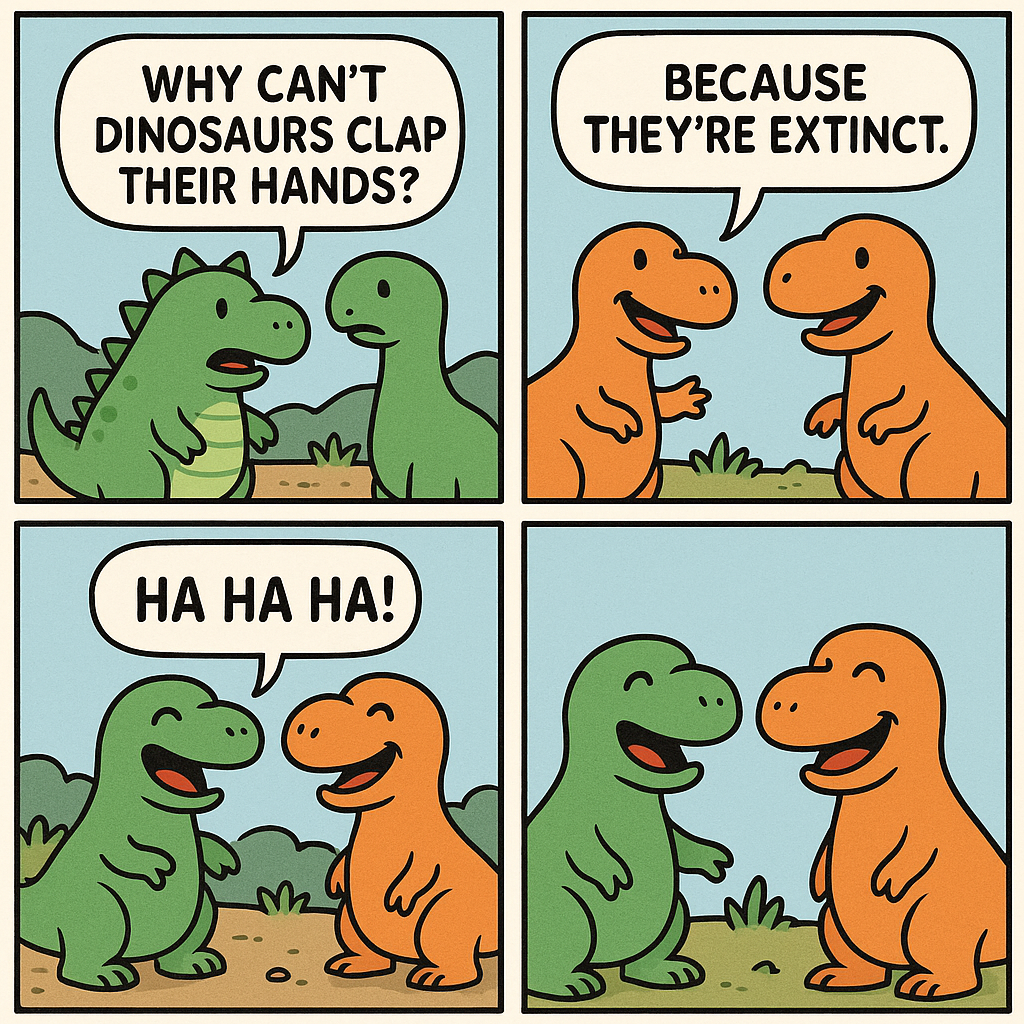

In [25]:
from IPython.display import Image, display

# Display the image
display(Image(filename='joke_example.png'))

### Image Resizing

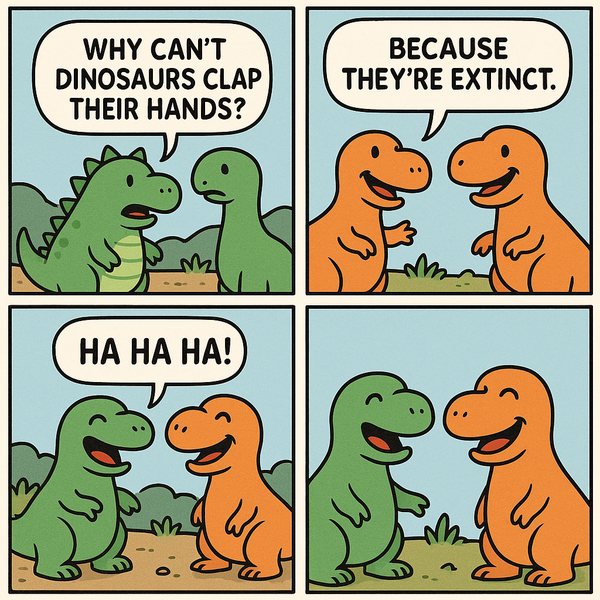

In [26]:
from PIL import Image
import base64, io, os

def encode_for_gemma(path, fmt="WEBP",
                     max_side=600, quality=78):
    """
    Compress -> strip metadata -> base64 for Gemma 3 prompts.
    """
    # Open & resize
    with Image.open(path) as im:
        rs = getattr(Image, "Resampling", Image).LANCZOS
        scale = max_side / max(im.size)
        if scale < 1.0:
            im = im.resize((round(im.width*scale),
                            round(im.height*scale)), rs)

        # Convert transparencies
        if fmt.upper() in ("JPEG", "WEBP", "AVIF") and im.mode in ("RGBA", "P"):
            im = im.convert("RGB")
        display(im)
        # Encode
        buf = io.BytesIO()
        im.save(buf, fmt, quality=quality,
                optimize=True, method=6)
    return base64.b64encode(buf.getvalue()).decode()
encoded_image=encode_for_gemma('joke_example.png')

In [27]:
image_system_prompt = """
You are a visual joke interpreter.

You will be shown an image, encoded in base64, that visually represents ONE of the following jokes. Each joke is short and relies on a pun or visual wordplay. Your job is to identify which joke the image is meant to illustrate.

1. What kind of shoes do frogs wear? Open-toad sandals.
2. I just built an ATM that only gives out coins. I don’t know why no one’s thought of it before: it just makes cents!
3. Did I ever tell you about the time I went mushroom foraging? It’s a story with a morel at the end.
4. What happened when two slices of bread went on a date? It was loaf at first sight.
5. Why do crabs never volunteer? Because they're shell-fish.
6. I had a quiet game of tennis today. There was no racket.
7. What's a shark's favorite saying? "Man overboard!"
8. What did one slice of bread say to the other before the race? You're toast!
9. I poured some water over a duck's back yesterday. I don't think he cared.
10. I'm such a good navigator, a self-driving car once asked me for directions.
11. Why do melons have weddings? They cantelope.
12. What did the bison say to his son when he left the ranch? Bi-son.
13. Watch what you say around the egg whites. They can't take a yolk.
14. I'm so good at fixing things, my motto is, "If it is broke, I'll still fix it."
15. Where did the pumpkins have their meeting? In the gourdroom.
16. What's the best way to save your dad jokes? In a dadda-base.
17. I got a new pen that can write under water. It can write other words too.
18. My boss said “dress for the job you want, not for the job you have.” So I went in as Batman.
19. I went to the aquarium this weekend, but I didn’t stay long. There’s something fishy about that place.
20. Why can't dinosaurs clap their hands? Because they're extinct.
21. I gave my handyman a to-do list, but he only did jobs 1, 3, and 5. Turns out he only does odd jobs.
22. Check the appropriate box to designate whether you are a cat:
    o I am a cat.
    x I am not a cat

Ignore any unrelated business language that may appear in the list. Only consider jokes with humorous intent.
"""

user_prompt = f"""
Here is the image, base64-encoded:

{encoded_image}

Please determine which joke this image is most likely to represent.


"""

In [28]:
payload = {
        "model": 'gemma3:4b',
        "messages": [
            {'role': 'system', 'content': image_system_prompt},
            {'role': 'user', 'content': user_prompt}
        ],
        "options": {
                "num_ctx": 60000
            },
    
        "stream": False,
    }

In [29]:
response=requests.post(LLM_CHAT_API,headers=headers,data=json.dumps(payload))
response.json()

{'model': 'gemma3:4b',
 'created_at': '2025-05-14T22:27:53.661102999Z',
 'message': {'role': 'assistant',
  'content': 'This is a tough one! The image is a massive, complex string of characters – essentially a random, dense, and completely nonsensical visual.\n\n**Therefore, the most accurate answer is: There is no joke.**\n\nIt’s a “what the heck” image designed to be confusing and disorienting. It’s a visual joke, relying on the absurdity of the data itself. \n\nI apologize for the challenge!\n'},
 'done_reason': 'stop',
 'done': True,
 'total_duration': 17926895054,
 'load_duration': 2111005942,
 'prompt_eval_count': 50499,
 'prompt_eval_duration': 14602686961,
 'eval_count': 90,
 'eval_duration': 1155956932}

> ⚠️ **Important Note**  
> If you do **not** properly set the `"num_ctx"` variable, your input will be **truncated to the default context length**, which can silently degrade performance or output quality.

Here’s a typical warning message you might see in the logs:

```bash
[GIN] 2025/05/02 - 15:49:41 | 200 |  993.652625ms | 10.203.0.198 | POST "/api/chat"
time=2025-05-02T15:50:18.205-07:00 level=WARN source=runner.go:154 msg="truncating input prompt" limit=2048 prompt=94537 keep=4 new=2048

# Embedding Models in Ollama

Ollama supports specialized embedding models like nomic-embed-text, designed to convert text into vector representations for tasks such as semantic search, clustering, and retrieval-augmented generation (RAG).


### 🚀 Getting Started
To generate embeddings using `nomic-embed-text`, you can utilize Ollama's REST API:

```bash

curl http://localhost:11434/api/embeddings \
  -d '{
    "model": "nomic-embed-text",
    "prompt": "The sky is blue because of Rayleigh scattering"
  }'
```
This command returns a vector embedding representing the semantic meaning of the input text.

### 🧠 Model Highlights
- **Context Length:** Supports up to 8192 tokens, accommodating long documents.

- **Performance:** Outperforms models like OpenAI's text-embedding-ada-002 on benchmarks such as MTEB and LoCo .

- **Open Source:** Fully open weights, training data, and code, ensuring transparency and reproducibility.

- **Multilingual Support:** nomic-embed-text-v2 incorporates a Mixture-of-Experts architecture, enhancing performance across multiple languages .


### Import Libraries

In [31]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


### Pull Embedding model

In [32]:
LLM_API_URL=f'{ollama_url}/api/pull' # Notice the pull api endpoint
payload={"model":'nomic-embed-text'}
headers = {"Content-Type": "application/json"}
response=requests.post(LLM_API_URL,headers=headers,data=json.dumps(payload))
# API Header, Data you are sending

### Getting Embeddings for each joke

In [33]:
LLM_EMB_API = f'{ollama_url}/api/embed'

# Initialize a list to store the resulting embedding vectors
joke_embeddings = []

# Iterate over each joke in the provided list
for joke in jokes:
    # Prepare the payload with the model name and input text
    payload = {
        "model": "nomic-embed-text",
        "input": joke
    }

    # Send a POST request to the embedding API
    response = requests.post(LLM_EMB_API, headers=headers, data=json.dumps(payload))

    # Raise an exception if the request was unsuccessful
    response.raise_for_status()

    # Parse the JSON response
    data = response.json()

    # Extract the embeddings from the response
    emb_list = data.get("embeddings", [])

    # Check if the response contains a single embedding vector
    if emb_list and isinstance(emb_list[0], (float, int)):
        # Convert the list to a NumPy array and append to the embeddings list
        joke_embeddings.append(np.array(emb_list, dtype=np.float32))
    else:
        # If multiple embeddings are returned, convert each to a NumPy array and extend the list
        joke_embeddings.extend(np.array(e, dtype=np.float32) for e in emb_list)



### Dimenionally reduce and Plot all in 2D

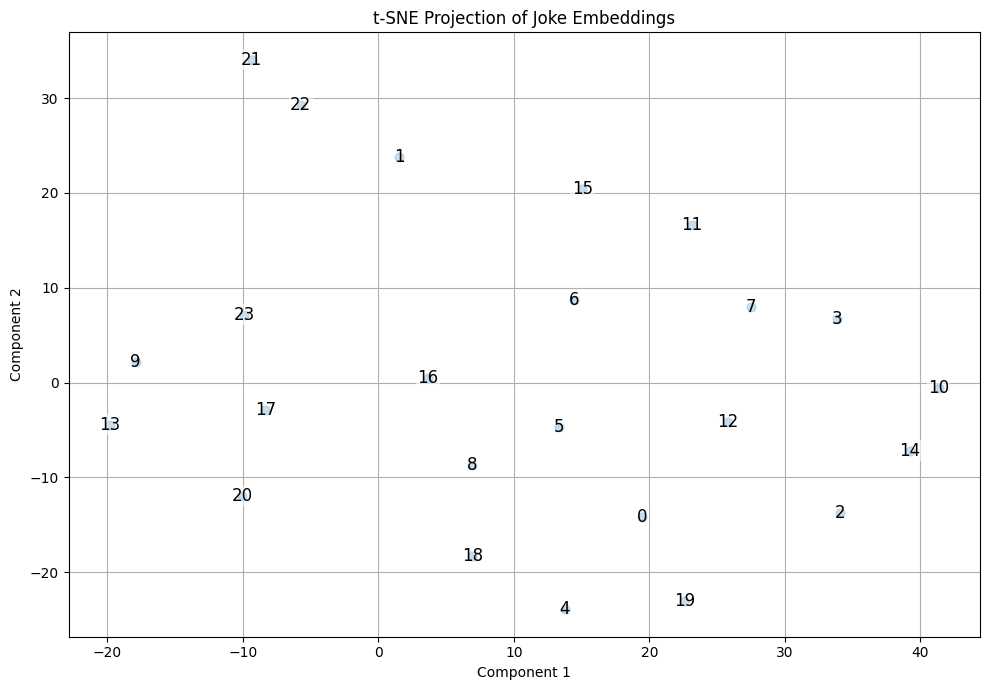

0: What kind of shoes to frogs wear? Open-toad sandals.
1: I just built an ATM that only gives out coins. I don’t know why no one’s thought of it before: it just makes cents!
2: Did I ever tell you about the time I went mushroom foraging? It’s a story with a morel at the end.
3: What happened when two slices of bread went on a date? It was loaf at first sight.
4: Why do crabs never volunteer? Because they're shell-fish.
5: I had a quiet game of tennis today. There was no racket.
6: What's a shark's favorite saying? "Man overboard!"
7: What did one slice of bread say to the other before the race? You're toast!
8: I poured some water over a duck's back yesterday. I don't think he cared.
9: I'm such a good navigator, a self-driving car once asked me for directions.
10: Why do melons have weddings? They cantelope.
11: What did the bison say to his son when he left the ranch? Bi-son.
12: Watch what you say around the egg whites. They can't take a yolk.
13: I'm so good at fixing things, my m

In [34]:
# Stack the list of embedding vectors into a 2D NumPy array
X = np.vstack(joke_embeddings)  # Shape: (n_jokes, embedding_dim)

# Initialize t-SNE with desired parameters
tsne = TSNE(n_components=2, perplexity=10, init='random', random_state=42)

# Fit and transform the embeddings to 2D
XY = tsne.fit_transform(X)

# Create a scatter plot of the 2D embeddings
plt.figure(figsize=(10, 7))
plt.scatter(XY[:, 0], XY[:, 1], s=40, alpha=0.6)

# Annotate each point with its index for clarity
for idx, (x, y) in enumerate(XY):
    plt.text(
        x, y, str(idx),
        fontsize=12,
        ha='center', va='center',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1)
    )

# Add plot titles and labels
plt.title('t-SNE Projection of Joke Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the list of jokes with their corresponding indices
for i, joke in enumerate(jokes):
    print(f"{i}: {joke}")